In [4]:
import numpy as np
import pandas as pd
import os,cv2,random,time,shutil,csv
import tensorflow as tf
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from tqdm import tqdm
import json,os,cv2,keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import BatchNormalization,Dense,GlobalAveragePooling2D,Lambda,Dropout,InputLayer,Input
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.preprocessing.image import load_img

In [5]:
train_dir='../input/dog-breed-identification/train'
test_dir='../input/dog-breed-identification/test'

In [239]:
labels_dataframe=pd.read_csv('../input/dog-breed-identification/labels.csv')
sample_df=pd.read_csv('../input/dog-breed-identification/sample_submission.csv')

In [7]:
labels_dataframe

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
...,...,...
10217,ffd25009d635cfd16e793503ac5edef0,borzoi
10218,ffd3f636f7f379c51ba3648a9ff8254f,dandie_dinmont
10219,ffe2ca6c940cddfee68fa3cc6c63213f,airedale
10220,ffe5f6d8e2bff356e9482a80a6e29aac,miniature_pinscher


In [8]:
labels_dataframe.shape

(10222, 2)

In [9]:
labels_dataframe.isnull().sum()

id       0
breed    0
dtype: int64

In [14]:
print("No of dog's images in train directory",len(os.listdir(train_dir)))
print("No of dog's images in test directory",len(os.listdir(test_dir)))

No of dog's images in train directory 10222
No of dog's images in test directory 10357


In [17]:
labels_dataframe['breed'].value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64

In [22]:
labels_dataframe['breed'].nunique()

120

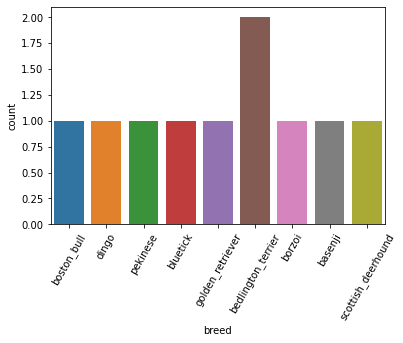

In [27]:
import warnings
warnings.filterwarnings(action='ignore')
import seaborn as sns
sns.countplot(labels_dataframe['breed'][:10])
plt.xticks(rotation=60)
plt.show()

In [33]:
dog_breeds=sorted(list(set(labels_dataframe['breed'])))
n_classes=len(dog_breeds)
print(n_classes)
print(dog_breeds[:15])

120
['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale', 'american_staffordshire_terrier', 'appenzeller', 'australian_terrier', 'basenji', 'basset', 'beagle', 'bedlington_terrier', 'bernese_mountain_dog', 'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound']


In [34]:
classes_to_num=dict(zip(dog_breeds,range(n_classes)))

In [35]:
classes_to_num

{'affenpinscher': 0,
 'afghan_hound': 1,
 'african_hunting_dog': 2,
 'airedale': 3,
 'american_staffordshire_terrier': 4,
 'appenzeller': 5,
 'australian_terrier': 6,
 'basenji': 7,
 'basset': 8,
 'beagle': 9,
 'bedlington_terrier': 10,
 'bernese_mountain_dog': 11,
 'black-and-tan_coonhound': 12,
 'blenheim_spaniel': 13,
 'bloodhound': 14,
 'bluetick': 15,
 'border_collie': 16,
 'border_terrier': 17,
 'borzoi': 18,
 'boston_bull': 19,
 'bouvier_des_flandres': 20,
 'boxer': 21,
 'brabancon_griffon': 22,
 'briard': 23,
 'brittany_spaniel': 24,
 'bull_mastiff': 25,
 'cairn': 26,
 'cardigan': 27,
 'chesapeake_bay_retriever': 28,
 'chihuahua': 29,
 'chow': 30,
 'clumber': 31,
 'cocker_spaniel': 32,
 'collie': 33,
 'curly-coated_retriever': 34,
 'dandie_dinmont': 35,
 'dhole': 36,
 'dingo': 37,
 'doberman': 38,
 'english_foxhound': 39,
 'english_setter': 40,
 'english_springer': 41,
 'entlebucher': 42,
 'eskimo_dog': 43,
 'flat-coated_retriever': 44,
 'french_bulldog': 45,
 'german_shepherd'

In [ ]:
../input/dog-breed-identification/train

In [57]:
(train_dir+'/'+labels_dataframe['id']+'.jpg')[0]

'../input/dog-breed-identification/train/000bec180eb18c7604dcecc8fe0dba07.jpg'

In [95]:
cv2.imread((train_dir+'/'+labels_dataframe['id']+'.jpg')[0]).shape

(375, 500, 3)

In [96]:
cv2.imread((train_dir+'/'+labels_dataframe['id']+'.jpg')[9]).shape

(332, 500, 3)

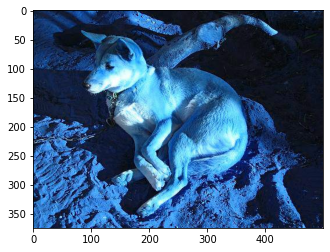

In [65]:
plt.imshow(cv2.imread((train_dir+'/'+labels_dataframe.id+'.jpg')[1]))

In [71]:
labels_dataframe['file_name']=labels_dataframe['id'].apply(lambda x: train_dir+'/'+f"{x}.jpg")
labels_dataframe

,id,breed,file_name
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,../input/dog-breed-identification/train/000bec...
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,../input/dog-breed-identification/train/001513...
2,001cdf01b096e06d78e9e5112d419397,pekinese,../input/dog-breed-identification/train/001cdf...
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,../input/dog-breed-identification/train/00214f...
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,../input/dog-breed-identification/train/0021f9...
...,...,...,...
10217,ffd25009d635cfd16e793503ac5edef0,borzoi,../input/dog-breed-identification/train/ffd250...
10218,ffd3f636f7f379c51ba3648a9ff8254f,dandie_dinmont,../input/dog-breed-identification/train/ffd3f6...
10219,ffe2ca6c940cddfee68fa3cc6c63213f,airedale,../input/dog-breed-identification/train/ffe2ca...
10220,ffe5f6d8e2bff356e9482a80a6e29aac,miniature_pinscher,../input/dog-breed-identification/train/ffe5f6...


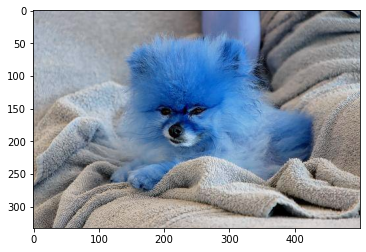

In [79]:
plt.imshow(cv2.imread(labels_dataframe['file_name'][8000]))

In [80]:
labels_dataframe['breed']=labels_dataframe['breed'].map(classes_to_num)
labels_dataframe

,id,breed,file_name
0,000bec180eb18c7604dcecc8fe0dba07,19,../input/dog-breed-identification/train/000bec...
1,001513dfcb2ffafc82cccf4d8bbaba97,37,../input/dog-breed-identification/train/001513...
2,001cdf01b096e06d78e9e5112d419397,85,../input/dog-breed-identification/train/001cdf...
3,00214f311d5d2247d5dfe4fe24b2303d,15,../input/dog-breed-identification/train/00214f...
4,0021f9ceb3235effd7fcde7f7538ed62,49,../input/dog-breed-identification/train/0021f9...
...,...,...,...
10217,ffd25009d635cfd16e793503ac5edef0,18,../input/dog-breed-identification/train/ffd250...
10218,ffd3f636f7f379c51ba3648a9ff8254f,35,../input/dog-breed-identification/train/ffd3f6...
10219,ffe2ca6c940cddfee68fa3cc6c63213f,3,../input/dog-breed-identification/train/ffe2ca...
10220,ffe5f6d8e2bff356e9482a80a6e29aac,75,../input/dog-breed-identification/train/ffe5f6...


In [82]:
y=to_categorical(labels_dataframe['breed'])
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [83]:
y.shape

(10222, 120)

# Feature Extraction

In [89]:
import keras
from keras.applications.inception_resnet_v2 import InceptionResNetV2,preprocess_input as resnet_preprocess
from keras.applications.inception_v3 import InceptionV3,preprocess_input as inception_preprocess
from keras.applications.xception import Xception , preprocess_input as xception_preprocess
from keras.applications.nasnet import NASNetLarge,preprocess_input as nasnet_preprocess
from keras.layers.merge import concatenate

In [103]:
input_shape=(331,331,3)
input_layer=Input(shape=(input_shape))

In [104]:
input_layer

<KerasTensor: shape=(None, 331, 331, 3) dtype=float32 (created by layer 'input_12')>

In [109]:
%%time
preprocess_resnet=Lambda(resnet_preprocess)(input_layer)
inception_resnet=InceptionResNetV2(weights='imagenet',include_top=False,
                                   input_shape=input_shape,pooling='avg')(preprocess_resnet)



preprocessor_inception=Lambda(inception_preprocess)(input_layer)
inception_v3=InceptionV3(weights='imagenet',include_top=False,
                                   input_shape=input_shape,pooling='avg')(preprocessor_inception)



preprocessor_xception=Lambda(xception_preprocess)(input_layer)
xception=Xception(weights='imagenet',include_top=False,
                                   input_shape=input_shape,pooling='avg')(preprocessor_xception)



preprocessor_nasnet=Lambda(nasnet_preprocess)(input_layer)
nasnet=NASNetLarge(weights='imagenet',include_top=False,
                                   input_shape=input_shape,pooling='avg')(preprocessor_nasnet)

CPU times: user 19.8 s, sys: 657 ms, total: 20.5 s
Wall time: 20.4 s


In [108]:
preprocess_resnet

<KerasTensor: shape=(None, 331, 331, 3) dtype=float32 (created by layer 'lambda_12')>

In [107]:
inception_resnet

<KerasTensor: shape=(None, 2048) dtype=float32 (created by layer 'inception_v3')>

In [110]:
%%time
merge=concatenate([inception_resnet,inception_v3,xception,nasnet])
model=Model(inputs=input_layer,outputs=merge)

CPU times: user 10.9 ms, sys: 57 µs, total: 11 ms
Wall time: 11.1 ms


In [111]:
merge

<KerasTensor: shape=(None, 9664) dtype=float32 (created by layer 'concatenate_18')>

In [112]:
model

In [113]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 331, 331, 3) 0                                            
__________________________________________________________________________________________________
lambda_16 (Lambda)              (None, 331, 331, 3)  0           input_12[0][0]                   
__________________________________________________________________________________________________
lambda_17 (Lambda)              (None, 331, 331, 3)  0           input_12[0][0]                   
__________________________________________________________________________________________________
lambda_18 (Lambda)              (None, 331, 331, 3)  0           input_12[0][0]                   
______________________________________________________________________________________________

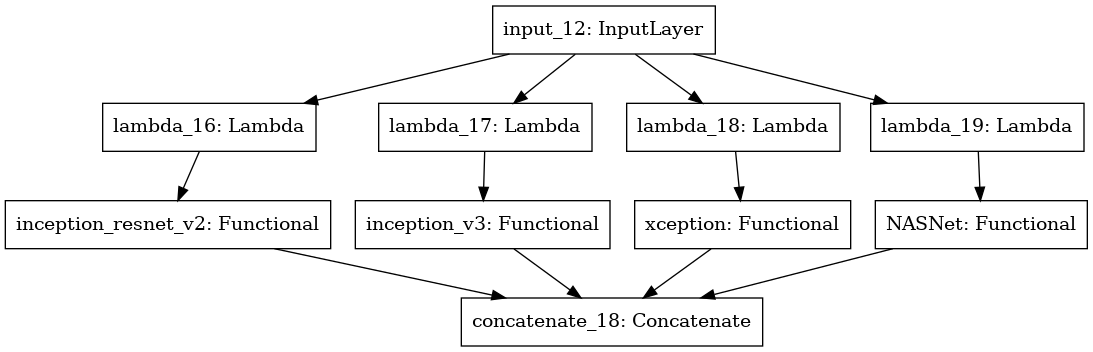

In [117]:
plot_model(model,show_shapes=False)

In [121]:
model.input.shape

TensorShape([None, 331, 331, 3])

In [127]:
model.output.shape

TensorShape([None, 9664])

In [124]:
len(model.trainable_weights)

1846

# Feature extraction by using pretrained model

In [133]:
def feature_extractor(df):
    img_size = (331,331,3)
    data_size = len(df)
    batch_size = 22
    x = np.zeros([data_size,9664], dtype=np.uint8)
    datagen = ImageDataGenerator()
    generator = datagen.flow_from_dataframe(df,x_col = 'file_name', class_mode = None, batch_size=batch_size, 
                                            shuffle = False,target_size = (img_size[:2]),color_mode = 'rgb')
    
    i = 0
    
    for input_batch in tqdm(generator):
        input_batch = model.predict(input_batch)
        x[i * batch_size : (i + 1) * batch_size] = input_batch
        i += 1
        if i * batch_size >= data_size:
            break
    return x
        

In [134]:
x=feature_extractor(labels_dataframe)

Found 10222 validated image filenames.


100%|█████████▉| 464/465 [09:47<00:01,  1.27s/it]


In [136]:
x

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [137]:
x.shape

(10222, 9664)

In [141]:
x[0].shape

(9664,)

In [153]:
from keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
earlystop=EarlyStopping(monitor='val_loss',patience=20,restore_best_weights=True)
checkpoint=ModelCheckpoint('kaggle/working/checkpoint',monitor='val_loss',mode='min',save_best_only=True)
lr=ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=3,min_lr=1e-6)
my_callback=[earlystop,checkpoint,lr]

# Let's create the model

In [146]:
x.shape[1:]

(9664,)

In [154]:
%%time
nn=keras.models.Sequential([
    
    InputLayer(x.shape[1:]),
    Dropout(0.7),
    Dense(n_classes,activation='softmax')
    
    
])

nn.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
h=nn.fit(x,y,batch_size=120,epochs=100,validation_split=0.20,callbacks=my_callback)

Epoch 1/100
69/69 [==============================] - 1s 5ms/step - loss: 3.9716 - accuracy: 0.5437 - val_loss: 2.9684 - val_accuracy: 0.8973
Epoch 2/100
69/69 [==============================] - 0s 4ms/step - loss: 2.2190 - accuracy: 0.9064 - val_loss: 1.7181 - val_accuracy: 0.9164
Epoch 3/100
69/69 [==============================] - 0s 4ms/step - loss: 1.3610 - accuracy: 0.9341 - val_loss: 1.1723 - val_accuracy: 0.9198
Epoch 4/100
69/69 [==============================] - 0s 4ms/step - loss: 0.9705 - accuracy: 0.9412 - val_loss: 0.9018 - val_accuracy: 0.9237
Epoch 5/100
69/69 [==============================] - 0s 4ms/step - loss: 0.7677 - accuracy: 0.9462 - val_loss: 0.7457 - val_accuracy: 0.9247
Epoch 6/100
69/69 [==============================] - 0s 5ms/step - loss: 0.6231 - accuracy: 0.9545 - val_loss: 0.6435 - val_accuracy: 0.9252
Epoch 7/100
69/69 [==============================] - 0s 4ms/step - loss: 0.5415 - accuracy: 0.9579 - val_loss: 0.5726 - val_accuracy: 0.9257
Epoch 8/100
6

# Plotting the results

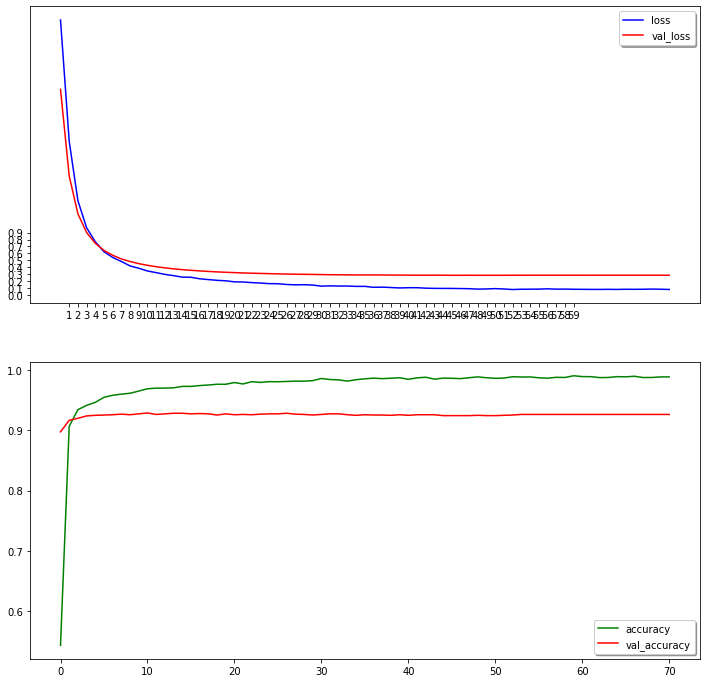

In [158]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

ax1.plot(h.history['loss'],color = 'b',label = 'loss')
ax1.plot(h.history['val_loss'],color = 'r',label = 'val_loss')
ax1.set_xticks(np.arange(1, 60, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))
ax1.legend(['loss','val_loss'],shadow = True)


ax2.plot(h.history['accuracy'],color = 'green',label = 'accuracy')
ax2.plot(h.history['val_accuracy'],color = 'red',label = 'val_accuracy')
ax2.legend(['accuracy','val_accuracy'],shadow = True)
plt.show()

# Working with test data

In [162]:
test_data=[]
ids=[]

for pic in os.listdir(test_dir):
    ids.append(pic.split('.')[0])
    test_data.append(test_dir+'/'+pic)

In [167]:
ids[0]

'09e51e17e2b756ff2ace8a87bd1443fa'

In [168]:
test_data[0]

'../input/dog-breed-identification/test/09e51e17e2b756ff2ace8a87bd1443fa.jpg'

In [169]:
test_dataframe=pd.DataFrame({'file_name':test_data})
test_dataframe

,file_name
0,../input/dog-breed-identification/test/09e51e1...
1,../input/dog-breed-identification/test/f7a3250...
2,../input/dog-breed-identification/test/bc6d50f...
3,../input/dog-breed-identification/test/7cbc041...
4,../input/dog-breed-identification/test/f3b603f...
...,...
10352,../input/dog-breed-identification/test/d28a328...
10353,../input/dog-breed-identification/test/e60f662...
10354,../input/dog-breed-identification/test/54f6834...
10355,../input/dog-breed-identification/test/0608afc...


In [170]:
test_features=feature_extractor(test_dataframe)

Found 10357 validated image filenames.


100%|█████████▉| 470/471 [10:22<00:01,  1.32s/it]


In [171]:
test_features

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [172]:
test_features.shape

(10357, 9664)

In [234]:
y_pred=nn.predict(test_features)
y_pred

array([[0.00000021, 0.00000005, 0.00000002, ..., 0.00000018, 0.00000014,
        0.00000117],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00006443, 0.00017554, 0.00008874, ..., 0.00008229, 0.00005001,
        0.00008426],
       ...,
       [0.00000165, 0.00001367, 0.00001424, ..., 0.236232  , 0.00000492,
        0.00000133],
       [0.00001707, 0.00000679, 0.00002003, ..., 0.00003544, 0.00000065,
        0.00000037],
       [0.00004135, 0.00023553, 0.00000701, ..., 0.00002059, 0.00003186,
        0.00057349]], dtype=float32)

In [228]:
np.set_printoptions(suppress=True)
y_pred

array([[0.00000021, 0.00000005, 0.00000002, ..., 0.00000018, 0.00000014,
        0.00000117],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00006443, 0.00017554, 0.00008874, ..., 0.00008229, 0.00005001,
        0.00008426],
       ...,
       [0.00000165, 0.00001367, 0.00001424, ..., 0.236232  , 0.00000492,
        0.00000133],
       [0.00001707, 0.00000679, 0.00002003, ..., 0.00003544, 0.00000065,
        0.00000037],
       [0.00004135, 0.00023553, 0.00000701, ..., 0.00002059, 0.00003186,
        0.00057349]], dtype=float32)

In [229]:
def get_key(val):
    for key, value in classes_to_num.items():
        if val==value:
            return key
        
pred_codes=np.argmax(y_pred,axis=1)
predictions=[]

for i in pred_codes:
    
    predictions.append(get_key(i))

In [230]:
pred_codes

array([104,  89,  69, ...,  60,  44,  70])

In [181]:
predictions[:25]

['staffordshire_bullterrier',
 'redbone',
 'leonberg',
 'italian_greyhound',
 'welsh_springer_spaniel',
 'rhodesian_ridgeback',
 'kerry_blue_terrier',
 'flat-coated_retriever',
 'staffordshire_bullterrier',
 'great_pyrenees',
 'borzoi',
 'whippet',
 'malamute',
 'border_collie',
 'chesapeake_bay_retriever',
 'mexican_hairless',
 'irish_water_spaniel',
 'basset',
 'irish_wolfhound',
 'schipperke',
 'pomeranian',
 'border_collie',
 'labrador_retriever',
 'leonberg',
 'newfoundland']

In [231]:
test_dataframe['breed']=predictions
test_dataframe[:10]

,file_name,breed
0,../input/dog-breed-identification/test/09e51e1...,staffordshire_bullterrier
1,../input/dog-breed-identification/test/f7a3250...,redbone
2,../input/dog-breed-identification/test/bc6d50f...,leonberg
3,../input/dog-breed-identification/test/7cbc041...,italian_greyhound
4,../input/dog-breed-identification/test/f3b603f...,welsh_springer_spaniel
5,../input/dog-breed-identification/test/db55098...,rhodesian_ridgeback
6,../input/dog-breed-identification/test/665bab0...,kerry_blue_terrier
7,../input/dog-breed-identification/test/7b57911...,flat-coated_retriever
8,../input/dog-breed-identification/test/df0d6ba...,staffordshire_bullterrier
9,../input/dog-breed-identification/test/b80d89a...,great_pyrenees


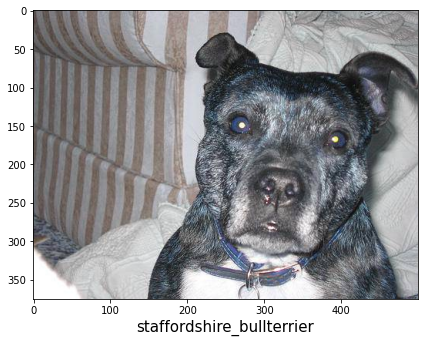

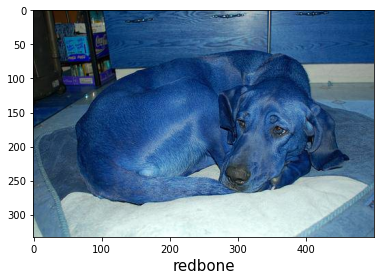

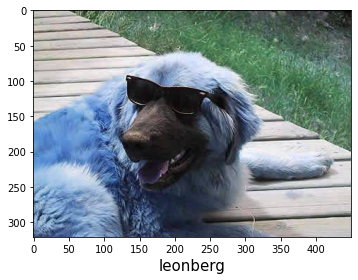

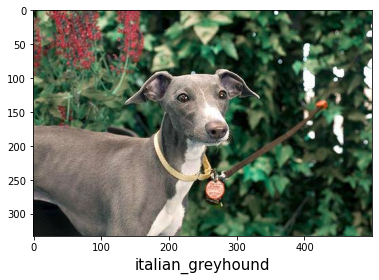

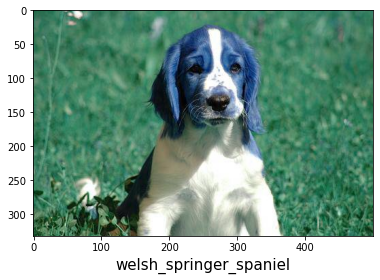

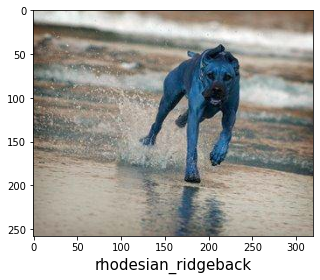

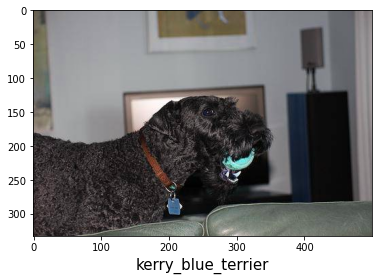

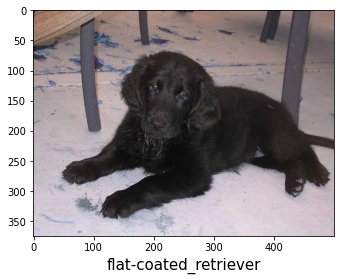

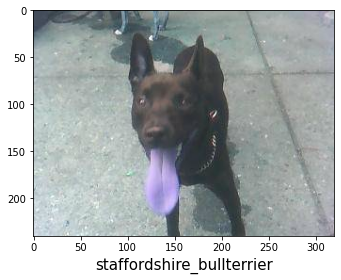

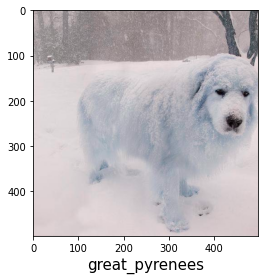

In [232]:
plt.figure(figsize=(6,6))

for index , data in test_dataframe[:10].iterrows():
    img = data['file_name']
    label = data['breed']
    img = cv2.imread(img)
#     plt.subplot(2,5, index+1)
    plt.imshow(img)
    plt.xlabel(label,fontsize = (15))
    plt.tight_layout()
    plt.show()    

In [235]:
submission=pd.DataFrame(y_pred,columns=classes_to_num.keys())
submission

,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,2.146035e-07,4.715509e-08,2.392595e-08,4.307029e-08,1.827058e-01,1.121825e-07,3.123752e-07,2.153253e-06,8.987016e-08,2.344472e-07,...,6.569636e-09,6.899920e-07,2.397346e-08,4.099610e-08,2.788512e-08,2.086361e-08,8.728549e-07,1.792809e-07,1.411542e-07,1.166928e-06
1,1.330163e-09,2.955242e-09,2.534212e-09,1.275911e-09,7.558456e-10,1.301811e-09,6.893696e-09,8.865435e-09,1.079046e-08,3.313871e-09,...,2.289408e-09,4.108484e-09,1.386739e-08,1.052507e-08,6.696039e-10,7.187998e-09,1.467699e-09,1.853581e-09,5.566499e-10,4.111719e-10
2,6.443081e-05,1.755448e-04,8.874103e-05,6.098273e-05,1.725375e-04,2.673438e-05,2.572215e-05,1.550364e-04,1.304543e-04,1.705240e-04,...,3.561426e-05,2.970947e-05,6.144724e-05,1.502323e-04,4.457675e-05,8.511026e-05,4.558618e-05,8.229352e-05,5.001265e-05,8.426410e-05
3,4.887603e-06,2.900790e-06,3.168015e-06,3.182991e-06,7.534394e-06,3.760659e-06,3.342564e-06,4.916011e-06,4.314224e-06,5.370742e-06,...,2.658773e-06,1.105535e-05,2.261070e-06,2.320262e-06,1.588482e-04,2.794647e-06,7.097578e-06,1.412851e-04,2.177875e-06,5.671974e-06
4,1.459650e-06,3.679983e-06,1.306411e-06,1.869367e-06,1.098114e-06,1.871606e-06,1.336810e-06,4.943714e-06,1.574557e-06,1.475859e-06,...,2.879540e-06,1.327929e-06,1.366540e-06,1.784967e-06,2.119109e-06,9.995913e-01,1.293805e-06,1.662155e-06,8.559134e-07,1.166477e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10352,3.966143e-07,3.380521e-07,1.346241e-06,4.425072e-07,2.212413e-07,2.284528e-07,7.421361e-08,3.350135e-07,9.520551e-08,7.817616e-08,...,1.416071e-07,3.161762e-07,2.806434e-07,4.254763e-07,4.979732e-07,1.357351e-07,1.984832e-07,9.778244e-07,1.750126e-07,6.203834e-07
10353,7.748643e-11,2.828045e-10,2.353994e-11,1.334534e-11,5.348402e-11,1.035341e-11,2.134068e-11,1.122964e-10,5.244725e-11,5.593864e-11,...,9.246372e-12,6.687818e-11,9.615696e-12,6.590138e-11,3.018388e-11,2.481059e-11,1.546042e-10,3.796363e-11,1.122228e-11,1.796174e-11
10354,1.653849e-06,1.367331e-05,1.424132e-05,5.728082e-06,5.841187e-06,8.611166e-07,6.049088e-07,5.626062e-06,9.549849e-06,7.797571e-06,...,4.614057e-06,1.629139e-06,1.159724e-06,3.170930e-05,2.916156e-04,4.427923e-06,3.659894e-06,2.362320e-01,4.917463e-06,1.328345e-06
10355,1.707401e-05,6.790068e-06,2.003083e-05,4.273320e-06,2.084550e-06,2.315563e-07,1.018152e-05,2.243226e-06,9.836189e-06,5.614870e-06,...,2.381721e-05,1.090662e-06,2.008283e-05,4.773483e-06,5.383612e-06,1.604392e-05,3.022791e-06,3.543769e-05,6.542395e-07,3.714302e-07


In [237]:
pd.set_option('display.float_format', lambda x: '%.15f' % x)
submission

,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,0.000000214603517,0.000000047155087,0.000000023925949,0.000000043070287,0.182705774903297,0.000000112182484,0.000000312375249,0.000002153252581,0.000000089870163,0.000000234447185,...,0.000000006569636,0.000000689991964,0.000000023973458,0.000000040996099,0.000000027885120,0.000000020863610,0.000000872854855,0.000000179280917,0.000000141154175,0.000001166927746
1,0.000000001330163,0.000000002955242,0.000000002534212,0.000000001275911,0.000000000755846,0.000000001301811,0.000000006893696,0.000000008865435,0.000000010790463,0.000000003313871,...,0.000000002289408,0.000000004108484,0.000000013867390,0.000000010525073,0.000000000669604,0.000000007187998,0.000000001467699,0.000000001853581,0.000000000556650,0.000000000411172
2,0.000064430809289,0.000175544759259,0.000088741027866,0.000060982729337,0.000172537475009,0.000026734380299,0.000025722145438,0.000155036395881,0.000130454282044,0.000170523955603,...,0.000035614255466,0.000029709470255,0.000061447244661,0.000150232328451,0.000044576750952,0.000085110259533,0.000045586180931,0.000082293518062,0.000050012647989,0.000084264102043
3,0.000004887602699,0.000002900789696,0.000003168015382,0.000003182990667,0.000007534394172,0.000003760658501,0.000003342563787,0.000004916010766,0.000004314223588,0.000005370741746,...,0.000002658773155,0.000011055351024,0.000002261070449,0.000002320261956,0.000158848168212,0.000002794647116,0.000007097577509,0.000141285068821,0.000002177874876,0.000005671973668
4,0.000001459650321,0.000003679982910,0.000001306410809,0.000001869367225,0.000001098113671,0.000001871606059,0.000001336809987,0.000004943714430,0.000001574556904,0.000001475859335,...,0.000002879540489,0.000001327929454,0.000001366539777,0.000001784967480,0.000002119109013,0.999591290950775,0.000001293805099,0.000001662155000,0.000000855913356,0.000001166476977
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10352,0.000000396614325,0.000000338052132,0.000001346240651,0.000000442507172,0.000000221241251,0.000000228452791,0.000000074213609,0.000000335013453,0.000000095205507,0.000000078176164,...,0.000000141607089,0.000000316176227,0.000000280643405,0.000000425476259,0.000000497973247,0.000000135735135,0.000000198483207,0.000000977824357,0.000000175012559,0.000000620383389
10353,0.000000000077486,0.000000000282805,0.000000000023540,0.000000000013345,0.000000000053484,0.000000000010353,0.000000000021341,0.000000000112296,0.000000000052447,0.000000000055939,...,0.000000000009246,0.000000000066878,0.000000000009616,0.000000000065901,0.000000000030184,0.000000000024811,0.000000000154604,0.000000000037964,0.000000000011222,0.000000000017962
10354,0.000001653849267,0.000013673306057,0.000014241316421,0.000005728081760,0.000005841186521,0.000000861116632,0.000000604908792,0.000005626062375,0.000009549848983,0.000007797571016,...,0.000004614056706,0.000001629139092,0.000001159724320,0.000031709299947,0.000291615579044,0.000004427923159,0.000003659893764,0.236231997609138,0.000004917463230,0.000001328345206
10355,0.000017074005882,0.000006790068255,0.000020030833184,0.000004273319973,0.000002084549578,0.000000231556285,0.000010181517609,0.000002243226163,0.000009836188838,0.000005614870133,...,0.000023817212423,0.000001090661840,0.000020082825358,0.000004773483397,0.000005383611551,0.000016043919459,0.000003022790906,0.000035437693441,0.000000654239500,0.000000371430218


In [240]:
sample_df

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,...,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333
1,00102ee9d8eb90812350685311fe5890,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,...,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333
2,0012a730dfa437f5f3613fb75efcd4ce,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,...,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333
3,001510bc8570bbeee98c8d80c8a95ec1,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,...,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333
4,001a5f3114548acdefa3d4da05474c2e,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,...,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10352,ffeda8623d4eee33c6d1156a2ecbfcf8,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,...,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333
10353,fff1ec9e6e413275984966f745a313b0,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,...,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333
10354,fff74b59b758bbbf13a5793182a9bbe4,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,...,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333
10355,fff7d50d848e8014ac1e9172dc6762a3,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,...,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333


In [241]:
sample_df=sample_df[['id']]
sample_df

,id
0,000621fb3cbb32d8935728e48679680e
1,00102ee9d8eb90812350685311fe5890
2,0012a730dfa437f5f3613fb75efcd4ce
3,001510bc8570bbeee98c8d80c8a95ec1
4,001a5f3114548acdefa3d4da05474c2e
...,...
10352,ffeda8623d4eee33c6d1156a2ecbfcf8
10353,fff1ec9e6e413275984966f745a313b0
10354,fff74b59b758bbbf13a5793182a9bbe4
10355,fff7d50d848e8014ac1e9172dc6762a3


In [242]:
submission=pd.merge(sample_df,submission,left_index=True,right_index=True)
submission

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0.000000214603517,0.000000047155087,0.000000023925949,0.000000043070287,0.182705774903297,0.000000112182484,0.000000312375249,0.000002153252581,0.000000089870163,...,0.000000006569636,0.000000689991964,0.000000023973458,0.000000040996099,0.000000027885120,0.000000020863610,0.000000872854855,0.000000179280917,0.000000141154175,0.000001166927746
1,00102ee9d8eb90812350685311fe5890,0.000000001330163,0.000000002955242,0.000000002534212,0.000000001275911,0.000000000755846,0.000000001301811,0.000000006893696,0.000000008865435,0.000000010790463,...,0.000000002289408,0.000000004108484,0.000000013867390,0.000000010525073,0.000000000669604,0.000000007187998,0.000000001467699,0.000000001853581,0.000000000556650,0.000000000411172
2,0012a730dfa437f5f3613fb75efcd4ce,0.000064430809289,0.000175544759259,0.000088741027866,0.000060982729337,0.000172537475009,0.000026734380299,0.000025722145438,0.000155036395881,0.000130454282044,...,0.000035614255466,0.000029709470255,0.000061447244661,0.000150232328451,0.000044576750952,0.000085110259533,0.000045586180931,0.000082293518062,0.000050012647989,0.000084264102043
3,001510bc8570bbeee98c8d80c8a95ec1,0.000004887602699,0.000002900789696,0.000003168015382,0.000003182990667,0.000007534394172,0.000003760658501,0.000003342563787,0.000004916010766,0.000004314223588,...,0.000002658773155,0.000011055351024,0.000002261070449,0.000002320261956,0.000158848168212,0.000002794647116,0.000007097577509,0.000141285068821,0.000002177874876,0.000005671973668
4,001a5f3114548acdefa3d4da05474c2e,0.000001459650321,0.000003679982910,0.000001306410809,0.000001869367225,0.000001098113671,0.000001871606059,0.000001336809987,0.000004943714430,0.000001574556904,...,0.000002879540489,0.000001327929454,0.000001366539777,0.000001784967480,0.000002119109013,0.999591290950775,0.000001293805099,0.000001662155000,0.000000855913356,0.000001166476977
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10352,ffeda8623d4eee33c6d1156a2ecbfcf8,0.000000396614325,0.000000338052132,0.000001346240651,0.000000442507172,0.000000221241251,0.000000228452791,0.000000074213609,0.000000335013453,0.000000095205507,...,0.000000141607089,0.000000316176227,0.000000280643405,0.000000425476259,0.000000497973247,0.000000135735135,0.000000198483207,0.000000977824357,0.000000175012559,0.000000620383389
10353,fff1ec9e6e413275984966f745a313b0,0.000000000077486,0.000000000282805,0.000000000023540,0.000000000013345,0.000000000053484,0.000000000010353,0.000000000021341,0.000000000112296,0.000000000052447,...,0.000000000009246,0.000000000066878,0.000000000009616,0.000000000065901,0.000000000030184,0.000000000024811,0.000000000154604,0.000000000037964,0.000000000011222,0.000000000017962
10354,fff74b59b758bbbf13a5793182a9bbe4,0.000001653849267,0.000013673306057,0.000014241316421,0.000005728081760,0.000005841186521,0.000000861116632,0.000000604908792,0.000005626062375,0.000009549848983,...,0.000004614056706,0.000001629139092,0.000001159724320,0.000031709299947,0.000291615579044,0.000004427923159,0.000003659893764,0.236231997609138,0.000004917463230,0.000001328345206
10355,fff7d50d848e8014ac1e9172dc6762a3,0.000017074005882,0.000006790068255,0.000020030833184,0.000004273319973,0.000002084549578,0.000000231556285,0.000010181517609,0.000002243226163,0.000009836188838,...,0.000023817212423,0.000001090661840,0.000020082825358,0.000004773483397,0.000005383611551,0.000016043919459,0.000003022790906,0.000035437693441,0.000000654239500,0.000000371430218


In [243]:
submission.to_csv('dog_breed_classifier2.csv',index=None)

In [244]:
pd.read_csv('dog_breed_classifier2.csv')

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0.000000214603520,0.000000047155087,0.000000023925950,0.000000043070287,0.182705770000000,0.000000112182484,0.000000312375250,0.000002153252600,0.000000089870160,...,0.000000006569636,0.000000689991960,0.000000023973458,0.000000040996100,0.000000027885120,0.000000020863610,0.000000872854860,0.000000179280920,0.000000141154170,0.000001166927700
1,00102ee9d8eb90812350685311fe5890,0.000000001330163,0.000000002955242,0.000000002534212,0.000000001275911,0.000000000755846,0.000000001301811,0.000000006893696,0.000000008865436,0.000000010790463,...,0.000000002289408,0.000000004108484,0.000000013867390,0.000000010525073,0.000000000669604,0.000000007187998,0.000000001467699,0.000000001853581,0.000000000556650,0.000000000411172
2,0012a730dfa437f5f3613fb75efcd4ce,0.000064430810000,0.000175544760000,0.000088741030000,0.000060982730000,0.000172537480000,0.000026734380000,0.000025722145000,0.000155036400000,0.000130454280000,...,0.000035614255000,0.000029709470000,0.000061447245000,0.000150232330000,0.000044576750000,0.000085110260000,0.000045586180000,0.000082293520000,0.000050012648000,0.000084264100000
3,001510bc8570bbeee98c8d80c8a95ec1,0.000004887602700,0.000002900789700,0.000003168015400,0.000003182990700,0.000007534394000,0.000003760658500,0.000003342563800,0.000004916010800,0.000004314223600,...,0.000002658773200,0.000011055351000,0.000002261070400,0.000002320262000,0.000158848170000,0.000002794647100,0.000007097577500,0.000141285070000,0.000002177874900,0.000005671973700
4,001a5f3114548acdefa3d4da05474c2e,0.000001459650300,0.000003679983000,0.000001306410800,0.000001869367200,0.000001098113700,0.000001871606100,0.000001336810000,0.000004943714400,0.000001574556900,...,0.000002879540500,0.000001327929500,0.000001366539800,0.000001784967500,0.000002119109000,0.999591300000000,0.000001293805100,0.000001662155000,0.000000855913360,0.000001166477000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10352,ffeda8623d4eee33c6d1156a2ecbfcf8,0.000000396614330,0.000000338052130,0.000001346240700,0.000000442507170,0.000000221241250,0.000000228452790,0.000000074213610,0.000000335013450,0.000000095205510,...,0.000000141607090,0.000000316176230,0.000000280643400,0.000000425476260,0.000000497973250,0.000000135735140,0.000000198483200,0.000000977824400,0.000000175012560,0.000000620383400
10353,fff1ec9e6e413275984966f745a313b0,0.000000000077486,0.000000000282804,0.000000000023540,0.000000000013345,0.000000000053484,0.000000000010353,0.000000000021341,0.000000000112296,0.000000000052447,...,0.000000000009246,0.000000000066878,0.000000000009616,0.000000000065901,0.000000000030184,0.000000000024811,0.000000000154604,0.000000000037964,0.000000000011222,0.000000000017962
10354,fff74b59b758bbbf13a5793182a9bbe4,0.000001653849300,0.000013673306000,0.000014241316000,0.000005728081800,0.000005841186500,0.000000861116630,0.000000604908800,0.000005626062400,0.000009549849000,...,0.000004614056700,0.000001629139100,0.000001159724300,0.000031709300000,0.000291615580000,0.000004427923000,0.000003659893800,0.236232000000000,0.000004917463200,0.000001328345200
10355,fff7d50d848e8014ac1e9172dc6762a3,0.000017074006000,0.000006790068300,0.000020030833000,0.000004273320000,0.000002084549600,0.000000231556290,0.000010181518000,0.000002243226200,0.000009836189000,...,0.000023817212000,0.000001090661800,0.000020082825000,0.000004773483400,0.000005383611600,0.000016043920000,0.000003022791000,0.000035437693000,0.000000654239500,0.000000371430220
